In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes, remove_small_objects, disk, opening, closing

(1296, 2304)


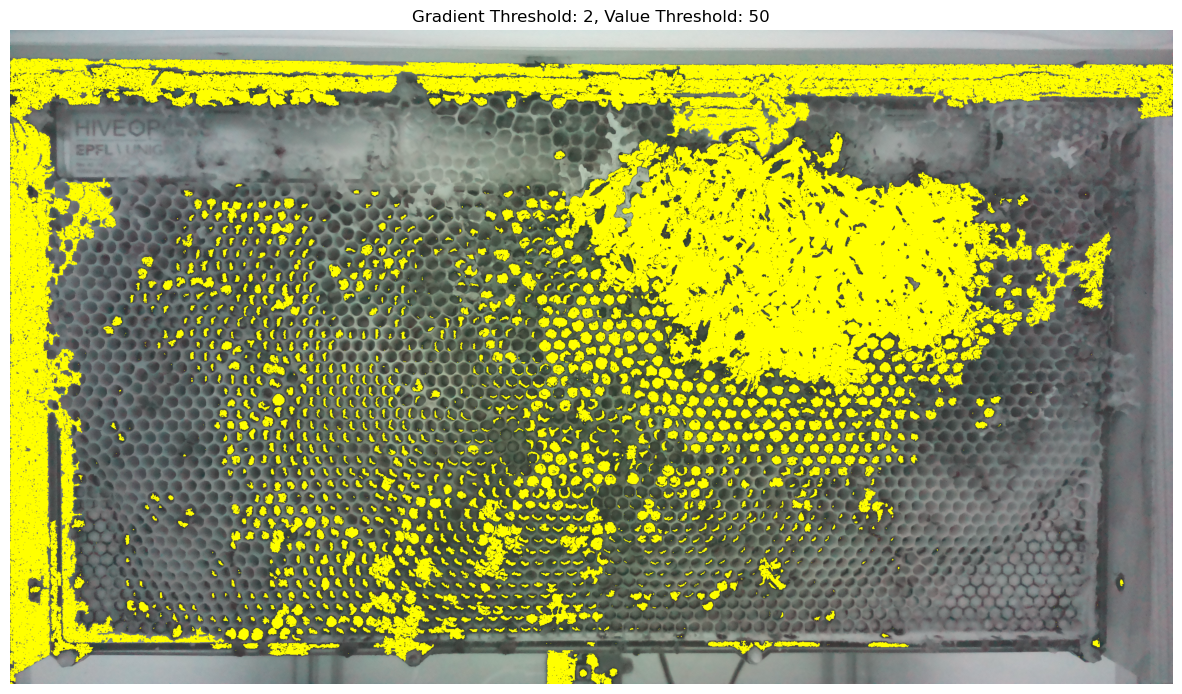

In [28]:
def rgb2gray(bgr):
    return np.dot(bgr[...,:3], [0.1140, 0.5870, 0.2989])

def region_growing(image, seed_point, visited, segmented_image, mask, threshold, value_threshold, max_iterations=10000):
    # Get image dimensions
    rows, cols = image.shape[:2]
    # Initialize queue for pixels to visit
    queue = []
    queue.append(seed_point)
    iterations = 0

    # Define 4-connectivity neighbors
    neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    while queue: # and iterations < max_iterations:
        iterations += 1
        # Get current pixel from queue
        current_point = queue.pop(0)
        segmented_image[current_point] = [255, 255, 0] # yellow like the bees 🐝
        mask[current_point] = 1
        visited[current_point] = 1

        for neighbor in neighbors:
            # Calculate neighbor coordinates
            x_neighbor, y_neighbor = current_point[0] + neighbor[0], current_point[1] + neighbor[1]

            # Check if neighbor is within image bounds
            if 0 <= x_neighbor < rows and 0 <= y_neighbor < cols:
                # Check if neighbor pixel is not visited
                if visited[x_neighbor, y_neighbor] == 0: #and (rgb2gray(image[x_neighbor, y_neighbor]) < value_threshold):
                    # Calculate gradient descent
                    gradient = abs(int(rgb2gray(image[current_point])) - int(rgb2gray(image[x_neighbor, y_neighbor])))
                    # Check if gradient is less than threshold
                    if gradient <= threshold:
                        queue.append((x_neighbor, y_neighbor))
                        visited[x_neighbor, y_neighbor] = 1

# Read input image
input_image = cv2.imread('clusters/h1r3_2.jpg')
input_image = cv2.resize(input_image, (0,0), fx=0.5, fy=0.5)

# Set threshold for region growing
gradient_thresholds = [2]
value_thresholds = [50]

rows, cols = input_image.shape[:2]

for gradient_threshold in gradient_thresholds:
    for value_threshold in value_thresholds:
        # Initialize visited matrix, taking only the first 2 dimensions of the input image
        visited = np.zeros((input_image.shape[0], input_image.shape[1]))
        mask = np.zeros((input_image.shape[0], input_image.shape[1]))
        print(mask.shape)
        # Initialize segmented image
        segmented_image = input_image.copy()
        # Perform region growing
        for x in range(rows):
            for y in range(cols):
                if (visited[x, y] == 0) and (rgb2gray(input_image[x, y]) < value_threshold):
                    region_growing(input_image, (x, y), visited, segmented_image, mask, gradient_threshold, value_threshold)
        # cv2.imwrite(f'test_grad_value/output_{gradient_threshold}_{value_threshold}.jpg', cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        ax.imshow(segmented_image, cmap='gray')
        ax.set_title(f'Gradient Threshold: {gradient_threshold}, Value Threshold: {value_threshold}')
        ax.axis('off')
        plt.show()

# Display result
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.title('Input Image')
# plt.axis('off')
# plt.imshow(input_image, cmap='gray')
# plt.subplot(122)
# plt.title('Segmented Image')
# plt.axis('off')
# plt.imshow(segmented_image, cmap='gray')

In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# ax.imshow(mask, cmap='gray')
# ax.set_title(f'Gradient Threshold: {gradient_threshold}, Value Threshold: {value_threshold}')
# ax.axis('off')
# plt.show()
print(mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [32]:
# save segmented image
cv2.imwrite('output.jpg', cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))
cv2.imwrite('mask_bw.jpg', mask * 255)


True

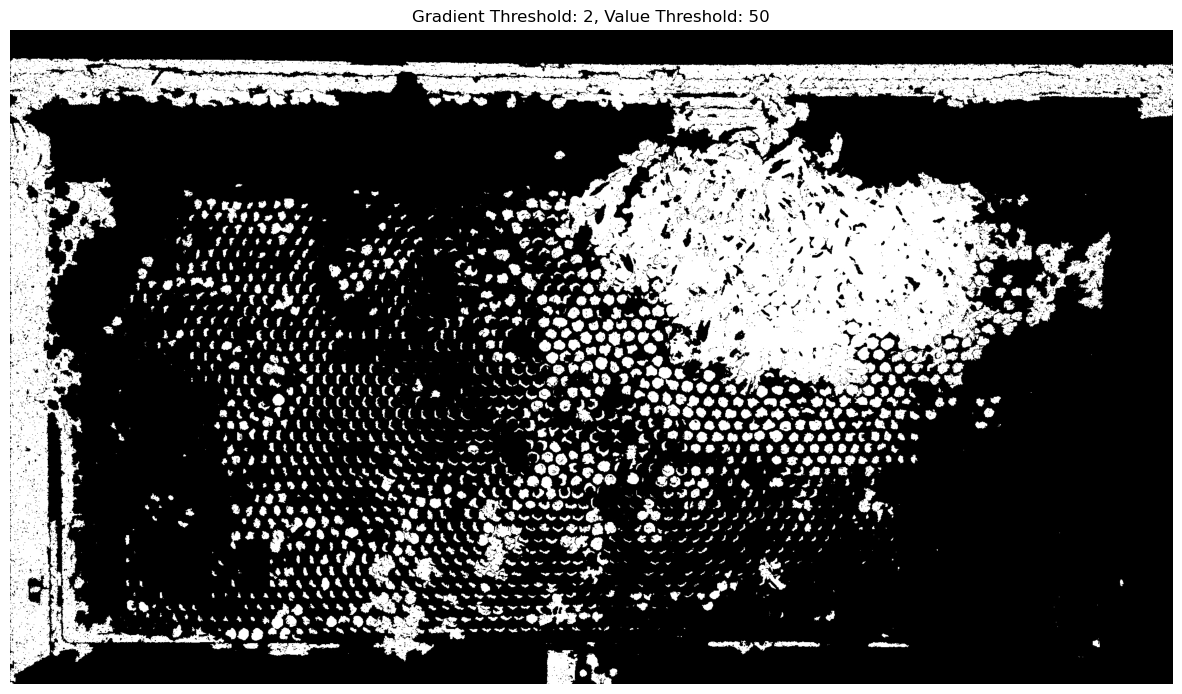

In [55]:
# load the mask
mask = cv2.imread('mask_bw.jpg', cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask, cmap='gray')
ax.set_title(f'Gradient Threshold: {gradient_threshold}, Value Threshold: {value_threshold}')
ax.axis('off')
plt.show()

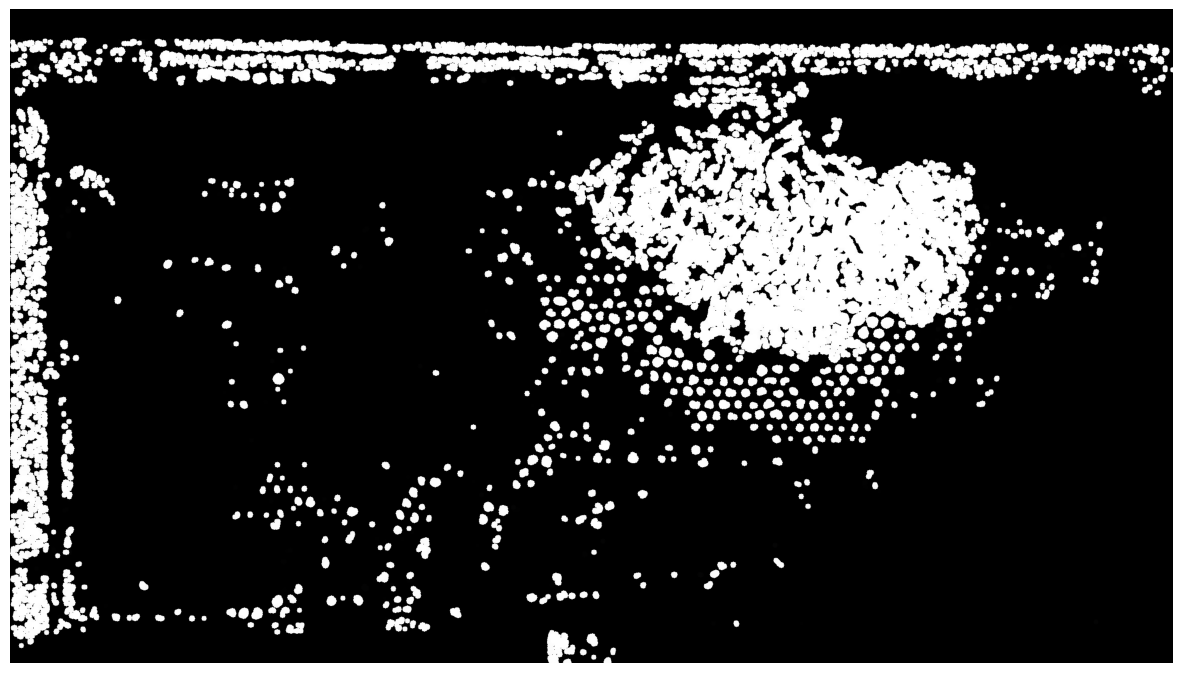

In [79]:
# morphology
mask_open1 = opening(mask, disk(5))

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask_open1, cmap='gray')
ax.axis('off')
plt.show()

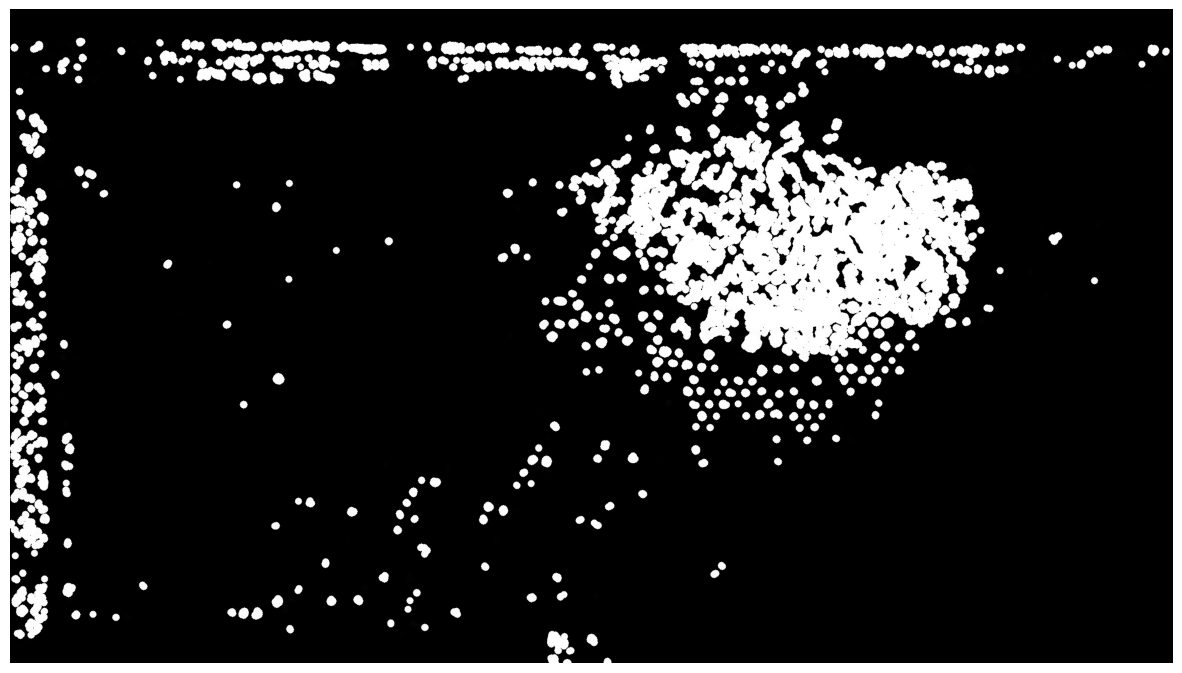

In [82]:
mask_open2 = opening(mask_open1, disk(7))

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask_open2, cmap='gray')
ax.axis('off')
plt.show()

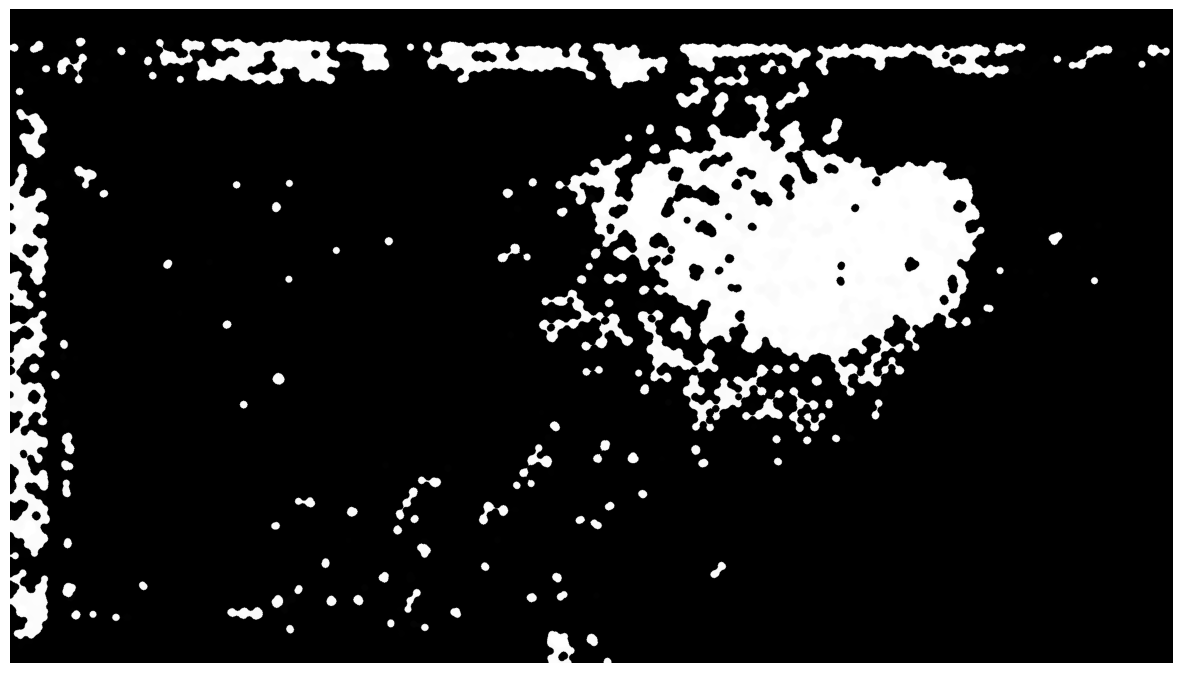

In [84]:
mask_closed = closing(mask_open2, disk(7))

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask_closed, cmap='gray')
ax.axis('off')
plt.show()

In [85]:
# find the contours
imgs_contour = []

# now we can find the contours

img_contour = (mask_closed).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
contour = max(contours, key=cv2.contourArea) #get the biggest contour
img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
cv2.drawContours(input_image, contour, -1, (255, 255, 255), 20) #draw the biggest contour
print('Area of the biggest contour:', cv2.contourArea(contour), "pixels") #print the area of the biggest contour
imgs_contour.append(img_contour)

Area of the biggest contour: 285428.5 pixels


In [92]:
# find the centroid of the contour
M = cv2.moments(contour)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
# plot it on the image
cv2.circle(input_image, (cX, cY), 10, (255, 0, 0), -1)
cv2.putText(input_image, "centroid", (cX - 30, cY - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 30)

array([[[129, 158, 163],
        [129, 158, 163],
        [129, 159, 164],
        ...,
        [168, 159, 171],
        [168, 157, 169],
        [171, 158, 172]],

       [[132, 157, 163],
        [133, 158, 164],
        [132, 157, 163],
        ...,
        [169, 161, 172],
        [166, 156, 168],
        [162, 150, 164]],

       [[140, 163, 169],
        [137, 159, 165],
        [139, 159, 165],
        ...,
        [168, 161, 172],
        [170, 162, 173],
        [169, 160, 173]],

       ...,

       [[ 46,  44,  53],
        [ 38,  39,  48],
        [ 36,  40,  47],
        ...,
        [118, 123, 128],
        [114, 119, 124],
        [114, 119, 124]],

       [[ 33,  39,  48],
        [ 29,  40,  48],
        [ 30,  48,  53],
        ...,
        [112, 112, 118],
        [113, 114, 119],
        [111, 110, 116]],

       [[ 20,  40,  46],
        [ 15,  40,  45],
        [ 20,  53,  55],
        ...,
        [114, 108, 115],
        [114, 109, 115],
        [112, 105, 112]]

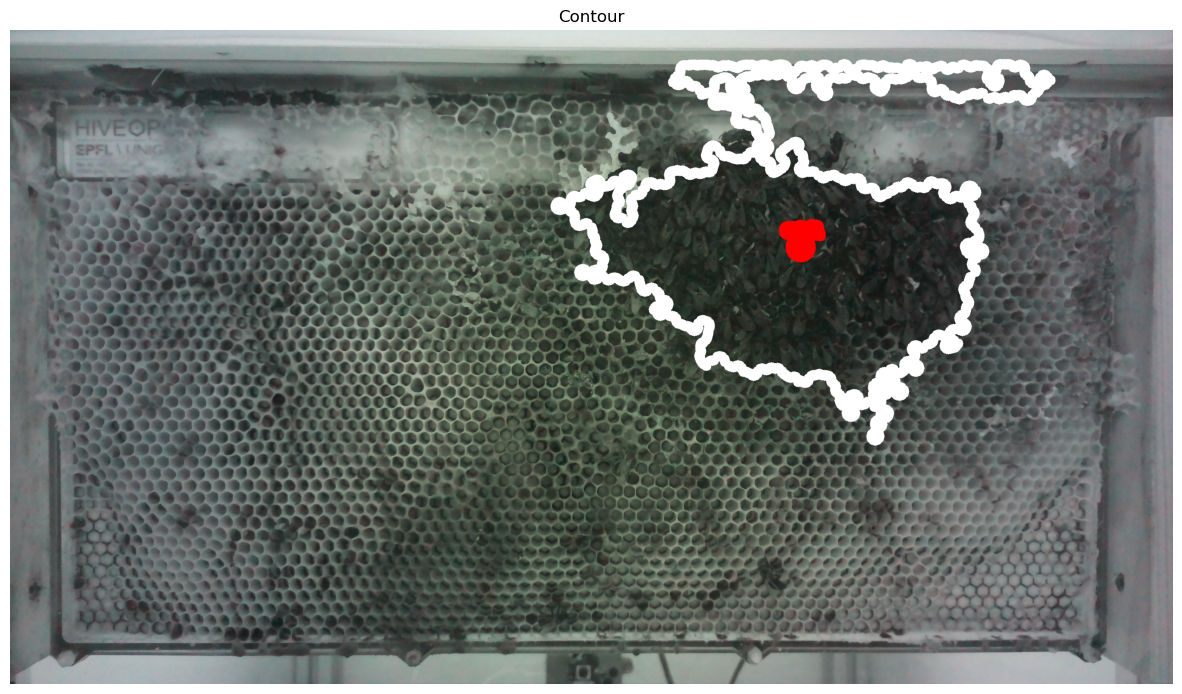

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(input_image, cmap='gray')
ax.axis('off')
ax.set_title('Contour')
plt.show()

# Results of tests on different value for the gradient threshold and the grayscale value threshold

This test was perfomed with a total of 6 different values for each threshold, respectively [5, 6, 7 ,8 ,9, 10] for gradient and [50, 60, 70, 80, 90, 100] for grayscale value.

The results, which can be seen in the 'test_grad_value' folder written as 'output_(gradient_threshold)_(grayscale_value_threshold).jpg', give the following conclusion :

- Grayscale threshold seems to yield the most effect on the characterisation of the algortihm; a smaller value yield smaller regions but are way less sensible to noise (black spot due to the illumination)

- Gradient value seems to refine results; might need some more test on a defined grayscale value threshold